# Using doNd functions in comparison to Measurement context manager for performing measurements

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be used to perform measurements. The `doNd` functions are generic wrappers of QCoDeS `Measurement` in zero, one, and two dimensions, as well as the general n dimension. To have a better picture of the difference between the two approaches, we compare `doNd` and `Measurement` side-by-side in some cases. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single-point measurements.

## Setup before measurement

Here, we call necessary imports for running this notebook, as well as setting up a database, dummy parameters, and creating an experiment object.

In [1]:
import os
import time
import numpy as np
from qcodes.utils.dataset.doNd import do1d, do2d, dond, plot, LinSweep, LogSweep, ArraySweep
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doNd.db')
initialise_or_create_database_at(tutorial_db_path)

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]

0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 1164.44it/s]

0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 384.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 1279.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 1372.03it/s]

First, we set up two dummy instruments to have something to measure. The dmm is set up to generate output depending on the values set on the dac simulating a real experiment.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

We create an experiment for the purpose of this notebook.

In [4]:
tutorial_exp = load_or_create_experiment('doNd_VS_Measurement', sample_name='no sample')

## 1D measurement

#### Measurement

We perform a one-dimensional sweep over a dac channel to measure our dmm voltages:

In [5]:
# Setting up Measurement
meas = Measurement(name= '1d_measurement of dmm from dac sweep', exp=tutorial_exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,))

# Running Measurement
with meas.run() as datasaver:
    for dac_sweep in np.linspace(0, 1, 10): # sweep points
        dac.ch1(dac_sweep)
        datasaver.add_result(
            (dac.ch1, dac.ch1()),
            (dmm.v1, dmm.v1()),
            (dmm.v2, dmm.v2())
            )
        time.sleep(0.01) # Can be removed if there is no intention to see a live plot

    dataset1 = datasaver.dataset

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #1, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

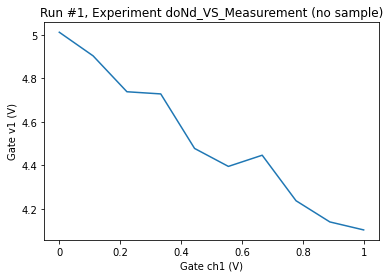

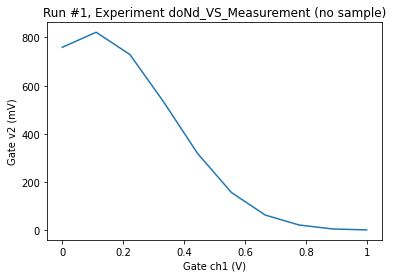

In [6]:
plot_dataset(dataset1)

#### do1d

Now let us use the `do1d` function to perform the above measurement.

In [7]:
# Running masurement with do1d
do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, show_progress=True)

Starting experimental run with id: 2. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

(results #2@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [None],
 [None])

By comparing `do1d` to a measurement implemented using the `Measurement` context manager, we notice that the `do1d` is significantly shorter, and much less typing is required to perform a basic measurement. This does however come at the cost of loss of flexibility. The `doNd` functions are therefore great for simple 0d, 1d, and 2d measurements but if you need to implement a more complicated type of measurement, the `Measurement` context manager is more well suited. However, the general `dond` function, which will be explained later in the notebook, is slightly more flexible than the rest of specific-dimensional ones, i.e., `do0d`, `do1d`, and `do2d`. 

By default, the `doNd` functions will not generate a plot of the output. This can be changed in one of two ways. For each individual call to `doNd`, one can set the value of the keyword argument `do_plot` to True. Alternatively, one can globally set the value of the setting `dataset.dond_plot` in the `qcodesrc.json` configuration file. In the examples below, we will often set `do_plot` to True to illustrate how the functions work and see the output figures right away. Note that this setting will be resulting to save the output as `png` and `pdf`.

For most use cases, we recommed using [Plottr](https://github.com/toolsforexperiments/plottr/) for live plotting. See [How to use plottr with QCoDeS for live plotting](../plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) for an introduction to Plottr.

Starting experimental run with id: 3. Using 'qcodes.utils.dataset.doNd.do1d'


(results #3@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #3, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #3, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

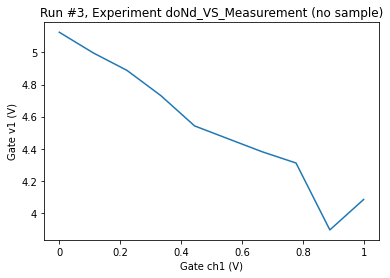

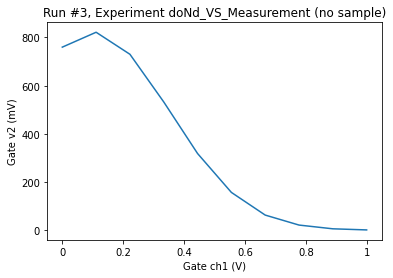

In [8]:
do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, do_plot = True)

Note that since DummyInstrumentWithMeasurement.v1 and v2 returns a result with simulated random noise, the results are not exactly the same as above.

## 2D measurement

Now, let us have a two dimensional sweep over gate voltages:

#### Measurement

In [9]:
# Setting up Measurement
meas = Measurement(name= '2d_measurement of dmm from dac sweep', exp=tutorial_exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,dac.ch2))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,dac.ch2))

# Running Measurement
with meas.run() as datasaver:
    for dac1_sweep in np.linspace(-1, 1, 20): # sweep points over channel 1
        dac.ch1(dac1_sweep)
        for dac2_sweep in np.linspace(-1, 1, 20): # sweep points over channel 2
            dac.ch2(dac2_sweep)
            datasaver.add_result(
                (dac.ch1, dac.ch1()),
                (dac.ch2, dac.ch2()),
                (dmm.v1, dmm.v1()),
                (dmm.v2, dmm.v2())
                )
            time.sleep(0.01) # Can be removed if there is no intention to see a live plot

    dataset2 = datasaver.dataset

Starting experimental run with id: 4. 


([<AxesSubplot:title={'center':'Run #4, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #4, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb164841be0>])

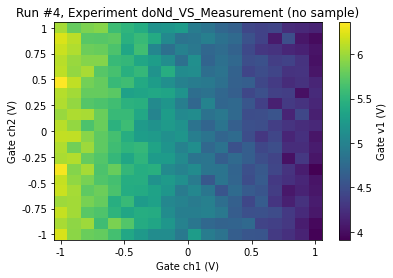

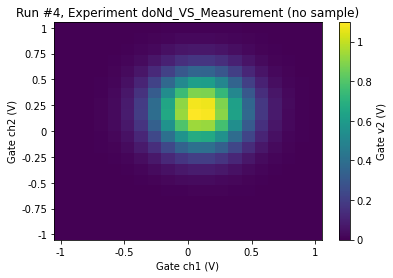

In [10]:
plot_dataset(dataset2)

#### do2d

Again, we use `do2d` to produce the results for the above measurement. As explained earlier, the results might look different compared to the Measurement section:

Starting experimental run with id: 5. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(results #5@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #5, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #5, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb1645de3a0>])

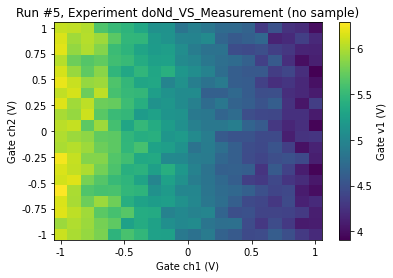

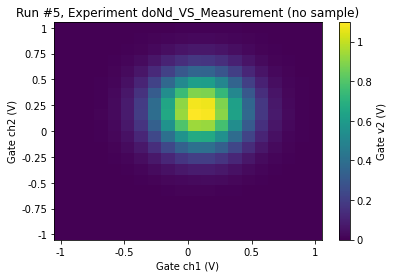

In [11]:
# Running masurement with do2d
do2d(dac.ch1, -1, 1, 20, 0.01, dac.ch2, -1, 1, 20, 0.01, dmm.v1, dmm.v2, do_plot = True, show_progress=True)

## Handling plot, experiment, and measurement_name with doNd

As discussed above the `doNd` functions can be configured to automatically call `plot_dataset` and save the output to `png` and `pdf` files. It is however also possible to generate these plots using the `plot` function in the dond module after a measurement is performed.

The `doNd` functions return a tuple of the dataset obtained in the measurement, a List of Matplotlib axes, and a list of Matplotlib colorbars and plot takes a dataset to be plotted along with keyword arguments that determine if a png or pdf file should be saved. One should therefore pass the first element of the tuple returned by `doNd` to the plot function.

As with the `Measurement` context manager, it is possible to pass an explicit `Experiment` object and `measurement_name` to the `doNd` functions. Then, one can easily switch between experiments and modify `measurement_name` when using the `doNd` functions.

In [12]:
result_1d = do1d(dac.ch1, 0, 0.25, 10, 0.01, dmm.v1, dmm.v2,
                 exp=tutorial_exp, measurement_name='1d_measurement of dmm from dac sweep')

Starting experimental run with id: 6. Using 'qcodes.utils.dataset.doNd.do1d'


In [13]:
result_2d = do2d(dac.ch1, -0.6, 0.6, 20, 0.01, dac.ch2, -0.6, 0.6, 20, 0.01, dmm.v1, dmm.v2,
                 exp=tutorial_exp, measurement_name='2d_measurement of dmm from dac sweep')

Starting experimental run with id: 7. Using 'qcodes.utils.dataset.doNd.do2d'


(1d_measurement of dmm from dac sweep #6@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 --------------------------------------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #6, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #6, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v2 (mV)'>],
 [None, None])

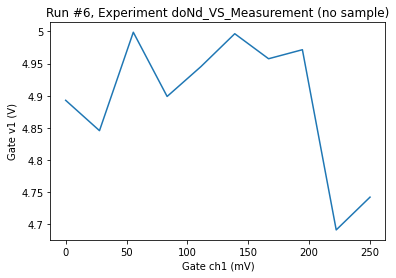

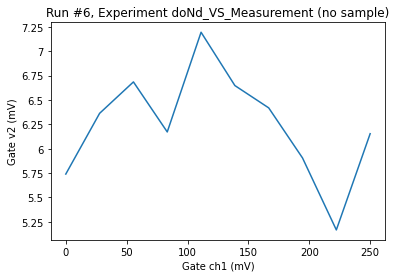

In [14]:
plot(result_1d[0], save_pdf = False, save_png =True)

(2d_measurement of dmm from dac sweep #7@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 --------------------------------------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #7, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>,
  <AxesSubplot:title={'center':'Run #7, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb16438ddc0>])

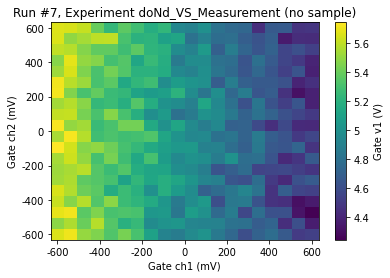

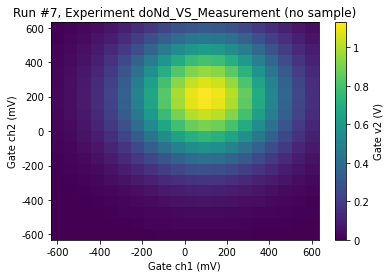

In [15]:
plot(result_2d[0], save_pdf = True, save_png = False)

## Generalized n-dimensional measurement (`dond`)

It is possible to use the general n-dimensional implementation in `doNd` (`dond` function) for performing measurements, which replaces individual 0, 1, and 2 dimensional functions with slightly different construct arguments. This implementation not only enables users to run higher dimensional measurements (above 2D) but also uses an interface for defining sweep setpoints other than traditional linearly-spaced points. Currently, `doNd` module has natively implemented linear and logarithmic setpoints in two sweep classes, i.e., `LinSweep`, `LogSweep` and `ArraySweep`. These classes are using the `AbstractSweep` interface structure defined in `doNd` module. Therefore, one can use this interface to create a sweep class with custom setpoints and use instances of that class in the `dond` construct for measurements. This could bring significant flexibility using `dond` over other specific-dimensional `doNd`s.

Below, we provide an example of how to replace the above-mentioned `do1d` and `do2d` with `dond`. Since individual `doNd`s are only limited to linearly-spaced sweep points, we use the existing `LinSweep` class instances with the structure shown below:

In [16]:
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)

Now, we can simply pass the created linear above sweep instances for measurements:

Starting experimental run with id: 8. Using 'qcodes.utils.dataset.doNd.dond'


  0%|          | 0/20 [00:00<?, ?it/s]

(results #8@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #8, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #8, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

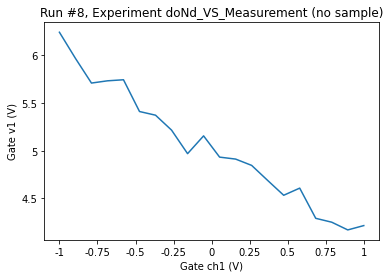

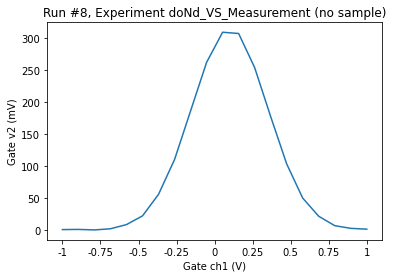

In [17]:
dond(sweep_1, dmm.v1, dmm.v2, do_plot=True, show_progress=True) # replacing above do1d example

Starting experimental run with id: 9. Using 'qcodes.utils.dataset.doNd.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(results #9@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #9, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #9, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb164112100>])

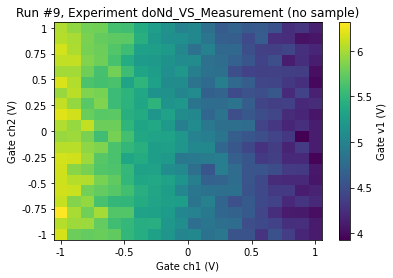

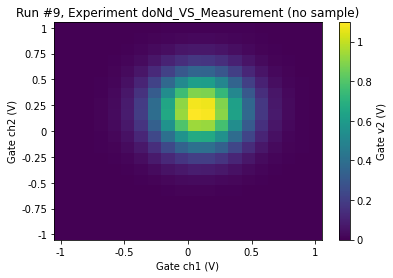

In [18]:
dond(sweep_1, sweep_2, dmm.v1, dmm.v2, do_plot=True, show_progress=True) # replacing above do2d example

Note that the results could be different from what we have seen before for the same reason explained earlier.

Let's try the above examples with logarithmic sweeps, instead:

In [19]:
sweep_3 = LogSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_4 = LogSweep(dac.ch2, -1, 1, 20, 0.01)

Starting experimental run with id: 10. Using 'qcodes.utils.dataset.doNd.dond'


  0%|          | 0/20 [00:00<?, ?it/s]

(results #10@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ----------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #10, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #10, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

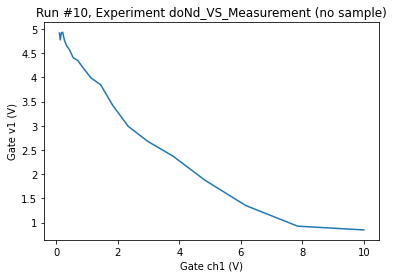

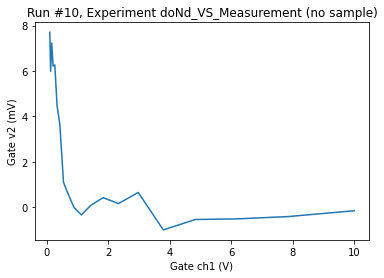

In [20]:
dond(sweep_3, dmm.v1, dmm.v2, show_progress=True, do_plot=True) # 1d

Starting experimental run with id: 11. Using 'qcodes.utils.dataset.doNd.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(results #11@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ----------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #11, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #11, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb15fed21c0>])

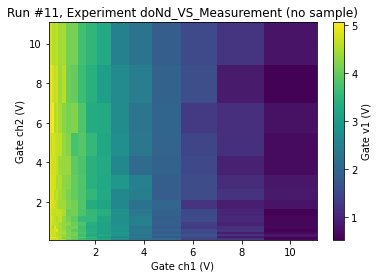

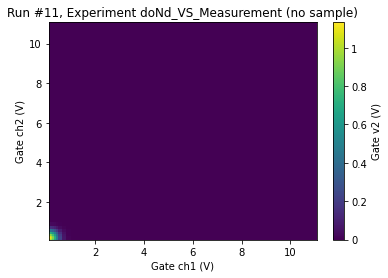

In [21]:
dond(sweep_3, sweep_4, dmm.v1, dmm.v2, show_progress=True, do_plot=True) # 2d

The `ArraySweep` can be used when you'd like to sweep a parameter with values of a more sophisticated array. Once you create the array, can be a numpy array or a sequence of values (list or tuple), then just pass it to `dond` wrapped in the `ArraySweep`, and that's it.

## dond with multiple measurements (multiple datasets)

If one wants to split measurement results into separate datasets, `dond` can do it with a small change in passing the arguments in this function. The user needs to group measurement parameters and their callables in sequences like lists or tuples, then `dond` will generate an independent measurement per group, and therefore, one dataset will be created for each group. It should be noted that all groups will share sweep setpoints, `Experiment` object, `measurement_name`, as well as `additional_setpoints`, if used.

Below, we provide a simple example how to create multiple datasets from `dond`:

Starting experimental run with id: 12. Using 'qcodes.utils.dataset.doNd.dond'
Starting experimental run with id: 13. Using 'qcodes.utils.dataset.doNd.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

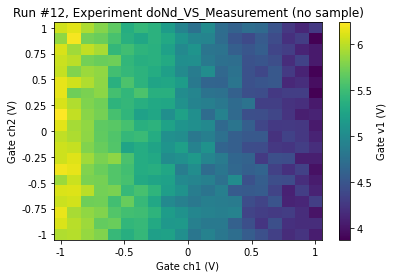

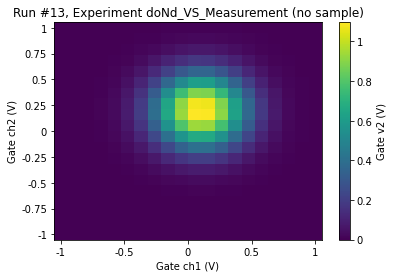

In [22]:
result = dond(sweep_1, sweep_2, [dmm.v1], [dmm.v2], do_plot=True, show_progress=True)

In this case, the output of `dond` is a triplet of tuples, which the first element of the triplet (`result[0]`) is the generated datasets:

In [23]:
dataset_v1 = result[0][0] # dataset for the first group
dataset_v2 = result[0][1] # dataset for the second group

## Actions in dond

All `doNd` functions except `do0d` support passing what we call them `action`s. These `action`s are `Callable`s, which can be used, for instance, if a user wants to perform some functions call before/ after setting a setpoint parameter. Here, we only demonstrate post_actions in `dond` because they are part of sweep classes rather than the `dond` function.

Let's walk through an example. We first define simple functions that only print some messages:

In [24]:
def action_1():
    print("dac channel 1 is set")
    print("********************")

def action_2():
    print("dac channel 2 is set")
    print("++++++++++++++++++++")

Now, we pass these functions into two sweep instances (note that `action`s should always be placed in a sequence like a list, even if there is only one `Callable`):

In [25]:
sweep_5 = LinSweep(dac.ch1, 0, 1, 2, 0.01, [action_1])
sweep_6 = LinSweep(dac.ch2, 0, 1, 2, 0.01, [action_2])

We intentionally chose two setpoints for each sweep instance to not populate our notebook with too many prints. Every time the parameter of `sweep_5` and `sweep_6` are set to their setpoint values, `action_1` and `action_2` will be called, respectively. Let's run a `dond` with these sweeps (here, we are only interested in actions, so we do not show the progress bar and plots):

In [26]:
dond(sweep_5, sweep_6, dmm.v1)

Starting experimental run with id: 14. Using 'qcodes.utils.dataset.doNd.dond'
dac channel 2 is set
++++++++++++++++++++
dac channel 2 is set
++++++++++++++++++++
dac channel 1 is set
********************
dac channel 2 is set
++++++++++++++++++++
dac channel 2 is set
++++++++++++++++++++


(results #14@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ----------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric,
 [None],
 [None])

If only inner actions between the outer loop and the inner loop are needed, then we only pass those actions into the outer-loop sweep object:

In [27]:
def action_wait():
    print("wait after setting dac channel 1")
    print("++++++++++++++++++++++++++++++++")

In [28]:
sweep_5 = LinSweep(dac.ch1, 0, 1, 2, 0.01, [action_1, action_wait])
sweep_6 = LinSweep(dac.ch2, 0, 1, 2, 0.01)

In [29]:
dond(sweep_5, sweep_6, dmm.v1)

Starting experimental run with id: 15. Using 'qcodes.utils.dataset.doNd.dond'
dac channel 1 is set
********************
wait after setting dac channel 1
++++++++++++++++++++++++++++++++


(results #15@/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/tutorial_doNd.db
 ----------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric,
 [None],
 [None])

These actions can be extremely useful in actual measurements that utilize `dond`. For example, If a user wants to run syncing the oscillator of two MFLI lockins after setting a frequency setpoint or starting an arbitrary waveform generator (AWG) upon sweeping a parameter, these functions can be triggered on instruments using the mentioned actions. 